# <font color='green'>NLP Project</font>

<div class="alert alert-block alert-warning">
<b>
Amirkabir University of Technology<br>
Fall 2022<br>
Course: Machine Learning<br>
Instructor: Dr. Seyedin<br>
<b><font color='green'>Author:</font></b><br>
Name: Reza hendi<br />
Student Number:9723144 </div>


***

In [ ]:
!pip install transformers
!pip install datasets
!pip install sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 49.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 55.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 5.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 KB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 16.5 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-whe

In [ ]:
from transformers import AutoTokenizer

from transformers import MobileBertTokenizer, TFMobileBertForSequenceClassification
import pandas as pd
import torch
import tensorflow as tf
import re
import string
import nltk
from nltk.corpus import stopwords 
nltk.download('stopwords')
from sklearn import metrics
from sentence_transformers import SentenceTransformer
import numpy as np

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# <font color='purple'>Loading the dataset from Hugging Face</font>

In [ ]:
from datasets import load_dataset
dataset = load_dataset('tweet_eval', 'hate')

Extracting data files:   0%|          | 0/6 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/9000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2970 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Dataset tweet_eval downloaded and prepared to /root/.cache/huggingface/datasets/tweet_eval/hate/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
print(dataset['train'][0])
print(dataset['test'][2])

{'text': '@user nice new signage. Are you not concerned by Beatlemania -style hysterical crowds crongregating on you…', 'label': 0}
{'text': '@user @user Those People Invaded Us!!! They DO NOT BELING HERE & HAVE NO RIGHTS! Its #AmericaFIRST! Open Your House To Them If Your That IGNORANT! & Yes Im A #Christian Too! #NODACA!', 'label': 1}


# <font color='purple'>Preprocessing Data</font>


In [ ]:
def preprocess_sentence(sentence):
    # remove punctuation
    sentence = sentence.translate(str.maketrans('', '', string.punctuation))
    # remove numbers
    sentence = re.sub(r'\d+', '', sentence)
    # remove whitespace
    sentence = sentence.strip()
    # remove stopwords
    sentence = ' '.join([word for word in sentence.split() if word not in stopwords.words('english')])
    return sentence

In [ ]:
def preprocess_dataset(dataset):
    dataset = dataset.map(lambda examples: {'text': preprocess_sentence(examples['text'])})
    return dataset

In [ ]:
dataset = preprocess_dataset(dataset)
print(dataset['train'][0])
print(dataset['test'][2])

  0%|          | 0/9000 [00:00<?, ?ex/s]

  0%|          | 0/2970 [00:00<?, ?ex/s]

  0%|          | 0/1000 [00:00<?, ?ex/s]

{'text': 'user nice new signage Are concerned Beatlemania style hysterical crowds crongregating you…', 'label': 0}
{'text': 'user user Those People Invaded Us They DO NOT BELING HERE HAVE NO RIGHTS Its AmericaFIRST Open Your House To Them If Your That IGNORANT Yes Im A Christian Too NODACA', 'label': 1}


In [ ]:
from sklearn.model_selection import train_test_split
data=dataset['train']['text']
labels=dataset['train']['label']
X_train, X_val, y_train, y_val = train_test_split(data,labels, test_size=0.2,stratify=labels)

In [ ]:

Mobile_bert_tokenizer = MobileBertTokenizer.from_pretrained("google/mobilebert-uncased")

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/847 [00:00<?, ?B/s]

In [ ]:
def convert_example_to_feature(review):
  return Mobile_bert_tokenizer.encode_plus(review, 
                add_special_tokens = True,     # add [CLS], [SEP]
                max_length = 512,              # max length of the text that can go to BERT
                padding='max_length',
                truncation=True,
                return_attention_mask = True,  # add attention mask to not focus on pad tokens
              )
# map to the expected input to TFBertForSequenceClassification
def map_example_to_dict(input_ids, attention_masks, token_type_ids, label):
  return {
      "input_ids": input_ids,
      "token_type_ids": token_type_ids,
      "attention_mask": attention_masks,
  }, label

def encode_examples(ds):
  # prepare list, so that we can build up final TensorFlow dataset from slices.
  input_ids_list = []
  token_type_ids_list = []
  attention_mask_list = []
  label_list = []
  for review, label in ds:
    bert_input = convert_example_to_feature(review)
    input_ids_list.append(bert_input['input_ids'])
    token_type_ids_list.append(bert_input['token_type_ids'])
    attention_mask_list.append(bert_input['attention_mask'])
    label_list.append([label])

  return tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, token_type_ids_list, label_list)).map(map_example_to_dict)

In [ ]:
batch_size = 8
# train dataset
ds_train = zip(data,labels)
ds_test = zip(X_val, y_val)
ds_train_encoded = encode_examples(ds_train).shuffle(len(data)).batch(batch_size)
ds_test_encoded = encode_examples(ds_test).batch(batch_size)

# <font color='purple'>Fine-tune a model</font>

In [ ]:
from transformers import TFMobileBertForSequenceClassification
Mobile_bert_model = TFMobileBertForSequenceClassification.from_pretrained("google/mobilebert-uncased")
Mobile_bert_model.trainable = True

Mobile_bert_model.summary()

Downloading:   0%|          | 0.00/164M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFMobileBertForSequenceClassification.

Some layers of TFMobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_mobile_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilebert (TFMobileBertMai  multiple                 24581888  
 nLayer)                                                         
                                                                 
 dropout_49 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1026      
                                                                 
Total params: 24,582,914
Trainable params: 24,582,914
Non-trainable params: 0
_________________________________________________________________


In [ ]:
learning_rate = 2e-5
# multiple epochs might be better as long as we will not overfit the model
number_of_epochs = 5

# choosing Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)
# we do not have one-hot vectors, we can use sparce categorical cross entropy and accuracy
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

Mobile_bert_model.compile(loss=loss,
                   optimizer=optimizer,
                   metrics=metric)

In [ ]:
# history=bert_model.fit(ds_train_encoded,
#                          batch_size=batch_size,
#                          epochs=number_of_epochs
#                          validation_data=ds_test_encoded)
history=Mobile_bert_model.fit(ds_train_encoded,
                         batch_size=batch_size,
                         epochs=number_of_epochs,
                         validation_data=ds_test_encoded)


Epoch 1/5
1125/1125 [==============================] - 682s 558ms/step - loss: 8106.0293 - accuracy: 0.5007 - val_loss: 1.0717 - val_accuracy: 0.4106
Epoch 2/5
1125/1125 [==============================] - 614s 546ms/step - loss: 5.3770 - accuracy: 0.5613 - val_loss: 0.7201 - val_accuracy: 0.5878
Epoch 3/5
1125/1125 [==============================] - 614s 545ms/step - loss: 2.1902 - accuracy: 0.6066 - val_loss: 0.6505 - val_accuracy: 0.6322
Epoch 4/5
1125/1125 [==============================] - 610s 542ms/step - loss: 0.6614 - accuracy: 0.6347 - val_loss: 0.6270 - val_accuracy: 0.6583
Epoch 5/5
1125/1125 [==============================] - 610s 542ms/step - loss: 0.6525 - accuracy: 0.6571 - val_loss: 0.6077 - val_accuracy: 0.6800


KeyError: ignored

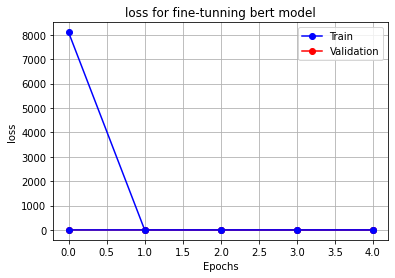

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], 'b-o')
plt.plot(history.history["val_loss"], 'r-o')
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("loss for fine-tunning bert model")
plt.legend(["Train", "Validation"])
plt.grid("on")
plt.savefig("Mobilebert-finetune-loss.png")


